In [1]:
import os
os.environ['AEON_DEPRECATION_WARNING'] = 'False'
os.environ['KMP_WARNINGS'] = 'off'

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)

import fnmatch

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import seaborn as sns
import scipy as sp
import scipy.fftpack as fp

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from scipy import stats

from aeon.transformations.collection.dictionary_based import PAA
import scipy.stats as stats

import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
path_queries = "queries/"

files_queries = {    
    "LenDB_queries.bin" : [256, np.float32],
    "SCEDC_queries.bin" : [256, np.float32],
    "Meier2019JGR_queries.bin" : [256, np.float32],
    "SIFT1b_queries.bin" : [256, np.float32],
    "OBS_queries.bin" : [256, np.float32],
    "bigANN_queries.bin" : [100, np.uint8],    
    "Iquique_queries.bin" : [256, np.float32],
    "astro_queries.bin": [256, np.float32],    
    "OBST2024_queries.bin" : [256, np.float32],
    "NEIC_queries.bin" : [256, np.float32],
    "STEAD_queries.bin" : [256, np.float32],
    "ETHZ_queries.bin" : [256, np.float32],
    "TXED_queries.bin" : [256, np.float32],
    "PNW_queries.bin" : [256, np.float32],
    "ISC_EHB_DepthPhases_queries.bin" : [256, np.float32],
    "SALD_queries.bin" : [256, np.float32],    
    "deep1b_queries.bin" : [96, np.float32],    
}    

path = "../data_head/"

In [3]:

from scipy.signal import find_peaks

def zero_crossings(key):
    # print(path_queries, key)
    file = path_queries + key
    length, data_type = files_queries[key]
    
    data = np.nan_to_num(np.fromfile(file, dtype=data_type))
    data = (data[:len(data)-len(data)%length].reshape(-1, length))
    data = np.nan_to_num(sp.stats.zscore(data, axis = 1))

    frequency_estimate = []    
    for signal in data:
        zero_crossings = np.where(np.diff(np.sign(signal)))[0]
        # print(zero_crossings, len(zero_crossings))
        
        # Compute the time differences between zero crossings
        if len(zero_crossings) > 1:
            # periods = np.diff(zero_crossings)  # Differences in indices
            periods = len(zero_crossings)
            average_period = np.mean(periods)  # Average period in samples
            frequency_estimate.append(average_period)  # Frequency estimate
        else:
            frequency_estimate.append(0)  # No zero crossings detected        

        # break
    
    return (np.mean(frequency_estimate) / length)

In [6]:
frequencies = {}
for i, file in enumerate(files_queries):
    key = file.replace("_queries", "").replace(".bin", "").replace("_", "-").replace("-Depth", "")
    freq = zero_crossings(file)
    # print(f"File:{key}    \t Freq: {freq}")
    frequencies[key] = [freq]

df_dominant_freq = pd.DataFrame(data=frequencies).T
df_dominant_freq.rename(columns={0:"Normalized Frequency"}, inplace=True)
df_dominant_freq["Freq"] = "Freq"
df_dominant_freq.sort_values("Normalized Frequency", inplace=True)
df_dominant_freq

,Normalized Frequency,Freq
ISC-EHBPhases,0.013581,Freq
OBS,0.015065,Freq
LenDB,0.027852,Freq
Meier2019JGR,0.063073,Freq
PNW,0.070482,Freq
NEIC,0.085143,Freq
ETHZ,0.090542,Freq
STEAD,0.140078,Freq
Iquique,0.190625,Freq
OBST2024,0.205156,Freq


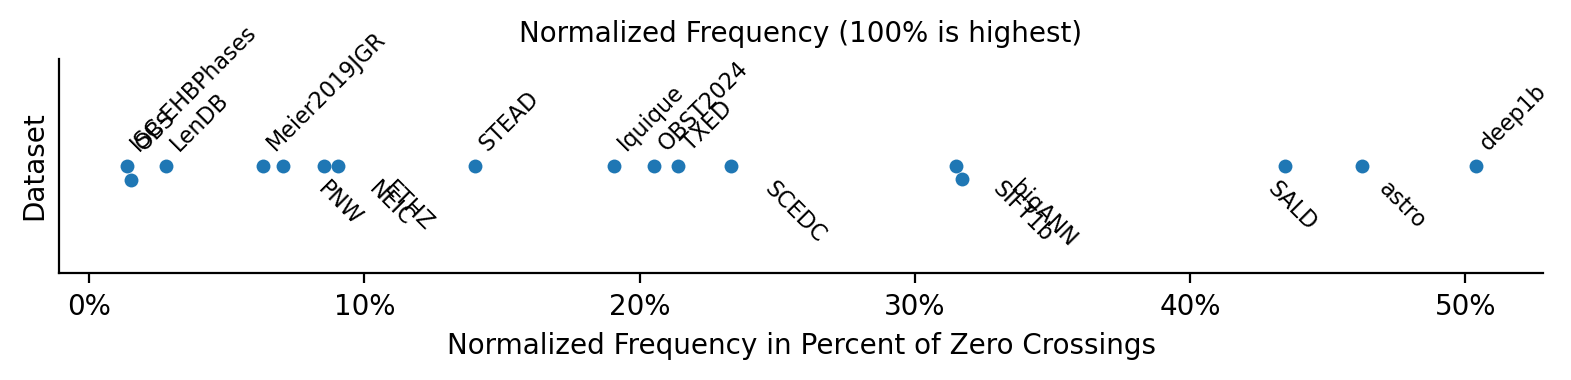

In [11]:
import warnings
warnings.filterwarnings("ignore", category=np.ComplexWarning)

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
sns.swarmplot(data=df_dominant_freq, y="Freq", x="Normalized Frequency", ax = ax)

sns.despine()
ax.set_title("Normalized Frequency (100% is highest)", size=10)
ax.set_ylabel("Dataset")
ax.set_yticks([])
ax.set_xlabel("Normalized Frequency in Percent of Zero Crossings")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
# ax.set_xlim([0,1])
# Add labels to the data points

above = 1
for i, point in enumerate(frequencies):
    # if frequencies[point][0] > 0.15 or  frequencies[point][0] < 0.05 :
        if above > 0:
            ax.text(
                x=frequencies[point][0],  #+ np.random.uniform(-0.02, +0.02),
                y=(0 - 0.05), # + np.random.uniform(-0.15, 0),
                s=point,
                fontsize=8,            
                ha='left',
                va='bottom',
                rotation=45  # Rotate labels by 90 degrees        
            )
        else:
            ax.text(
                x=frequencies[point][0] + np.random.uniform(-0.02, +0.02),
                y=(0 + 0.05), # + np.random.uniform(-0.15, 0),
                s=point,
                fontsize=8,            
                ha='left',
                va='top',
                rotation=-45  # Rotate labels by 90 degrees        
            )
        above *= -1

plt.tight_layout()
        
plt.savefig("images/dataset_frequency.pdf", bbox_inches='tight')
plt.show()

